# LogisticRegression 对数/逻辑回归

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. 逻辑回归
在这部分练习中，你将建立一个逻辑回归模型来预测学生是否进入大学。  
假设你是大学系的管理员，并且你希望根据他们在两门考试中的成绩来确定每位申请人的入学机会。  
你可以使用以前申请人的历史数据作为逻辑回归的训练集。对于每个培训示例，你都有申请人在两门考试中的分数和录取决定。  
你的任务是建立一个分类模型，根据这两个考试的分数估算申请人的录取概率。
### 导入数据集1

In [2]:
datafile = 'ex2data1.txt'
# 数据格式：成绩1,成绩2,是否录取
cols = np.loadtxt(datafile, delimiter=",", usecols=(0, 1, 2), unpack=True)
# cols=[[x11,x12,x13,...,x1m]
#       [x21,x22,x23,...,x2m]
#       [y1,y2,y3,...,ym]]
X = np.transpose(np.array(cols[:-1]))  # 等效于cols[:2] 取cols的前两个元素（上面的x1数组和x2数组）
y = np.transpose(np.array(cols[-1:]))
m = y.size
X = np.insert(X, 0, 1, axis=1)  # 在前面插入x0 = 1
# X=[x0,x1,x2]

### 1.1 数据可视化

In [3]:
# 把数据分成两类，通过（positive）和不通过(negative)
# X.shape = (100,3)，X.shape[0]=100
pos = np.array([X[i] for i in range(X.shape[0])if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0])if y[i] == 0])
# 检查是否包含所有项
print("Included everything? ", (len(pos)+len(neg) == X.shape[0]))

Included everything?  True


Text(0.5,1,'Figure 1 : Scatter plot of training data')

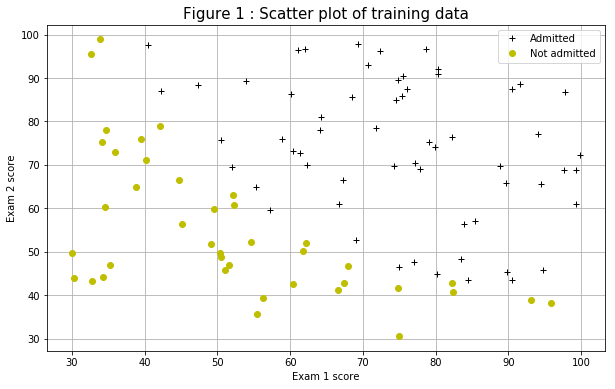

In [4]:
def plotData():
    plt.figure(figsize=(10, 6))
    plt.plot(pos[:, 1], pos[:, 2], 'k+', label='Admitted')
    plt.plot(neg[:, 1], neg[:, 2], 'yo', label='Not admitted')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend()
    plt.grid(True)

plotData()
plt.title("Figure 1 : Scatter plot of training data", fontsize=15)

### 1.2 算法实现
#### 1.2.1 sigmod函数

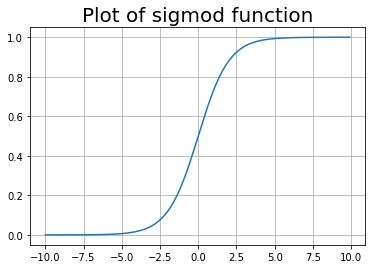

In [5]:
from scipy.special import expit  # 向量化的logistic函数

# 快速检查一下expit是不是像我们想的那样工作
myx = np.arange(-10, 10, .1)
plt.plot(myx, expit(myx))
plt.title("Plot of sigmod function", fontsize=20)
plt.grid(True)

#### 1.2.2 代价函数和梯度
* 补充知识
  * 梯度（gradient）：函数在某一点的梯度是这样一个向量，它的方向与取得最大方向导数的方向一致，而它的模为方向导数的最大值。 
  * 这里注意三点： 
    1. 梯度是一个向量，即有方向有大小； 
    2. 梯度的方向是最大方向导数的方向； 
    3. 梯度的值是最大方向导数的值。

In [6]:
# 假设函数
def h(mytheta, myX):  
    return expit(np.dot(myX, mytheta))

# 带可选正则化（默认没有）的代价函数
def computeCost(mytheta, myX, myy, mylambda=0.):    
    """
    theta_start 关于初始theta猜测值的n维向量
    X m行n列矩阵
    y m行1列矩阵（向量）
    注意这里如果将mylambda设为非0值，就包含了正则化
    对于第一部分的作业, mylambda取默认值0.
    """
    # *.shape is (rows, columns)(行,列)
    term1 = np.dot(-np.array(myy).T, np.log(h(mytheta, myX)))
    term2 = np.dot((1-np.array(myy)).T, np.log(1-h(mytheta, myX)))
    regterm = (mylambda/2) * \
        np.sum(np.dot(mytheta[1:].T, mytheta[1:]))  # Skip theta0
    return float((1./m) * (np.sum(term1 - term2) + regterm))


# 用为零的theta进行测试，返回0.693:
initial_theta = np.zeros((X.shape[1], 1))
computeCost(initial_theta, X, y)

0.6931471805599453

#### 1.2.3 使用fminuc学得参数
作为OCTAVE中'fminunc'函数的替代品，我们将使用scipy.optimize下的方法 "fmin"  
注意 "fmin" 不需要其他条件，它只需要代价函数, 而且使用"downhill simplex algorithm"单纯形法  
http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fmin.html

In [7]:
from scipy import optimize  # 最优化函数库

def optimizeTheta(mytheta, myX, myy, mylambda=0.):  # 最小化theta
    result = optimize.fmin(computeCost, x0=mytheta, args=(
        myX, myy, mylambda), maxiter=400, full_output=True)
    return result[0], result[1]

theta, mincost = optimizeTheta(initial_theta, X, y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [8]:
# 将最小化的theta代入代价函数
# 获得代价值为 0.203."
computeCost(theta, X, y)

0.2034977015902151

#### 1.2.4 评估逻辑回归
可视化决策边界

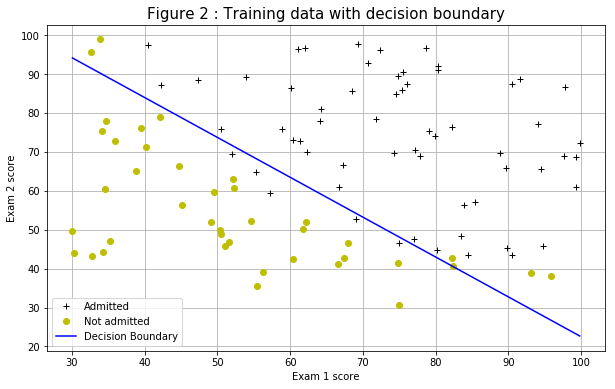

In [9]:
# 绘制决策边界: 画两个点，连线
# 当h=0或theta0 + theta1*x1 + theta2*x2 = 0时，取到决策边界
# y=mx+b 被 x2 = (-1/thetheta2)(theta0 + theta1*x1) 替换

boundary_xs = np.array([np.min(X[:, 1]), np.max(X[:, 1])])
boundary_ys = (-1./theta[2])*(theta[0] + theta[1]*boundary_xs)
plotData()
plt.title("Figure 2 : Training data with decision boundary", fontsize=15)
plt.plot(boundary_xs, boundary_ys, 'b-', label='Decision Boundary')
plt.legend()

In [10]:
# 输出对于[1, 45.,85.]的假设值
# 对于一个Exam1成绩为45，Exam2成绩为85的学生,
# 通过可能性应该是 0.776.
print(h(theta, np.array([1, 45., 85.])))

def makePrediction(mytheta, myx):   # 根据假设值作出预测
    return h(mytheta, myx) >= 0.5

0.7762915904112411


In [11]:
# 计算正确预测训练样本的比例
pos_correct = float(np.sum(makePrediction(theta, pos)))
neg_correct = float(np.sum(np.invert(makePrediction(theta, neg))))
tot = len(pos)+len(neg)
prcnt_correct = float(pos_correct+neg_correct)/tot
print("正确预测训练样本的比例: %f." % prcnt_correct)

正确预测训练样本的比例: 0.890000.


## 2. 带正则化的逻辑回归
在本练习的这一部分中，你将实施正则化逻辑回归，以预测来自制造工厂的芯片是否通过质量保证（QA）。  
假设你是工厂的产品经理，并且你在两个不同的测试中获得了一些芯片的测试结果。从这两个测试中，你想确定是应该接受还是拒绝芯片。  
为了帮助你做出决定，你可以在过去的芯片上获得测试结果的数据集，从中可以构建逻辑回归模型。
### 导入数据集2

In [12]:
datafile = 'ex2data2.txt'
# 数据格式：测试1,测试2,是否合格
cols = np.loadtxt(datafile, delimiter=",", usecols=(0, 1, 2), unpack=True)
# cols=[[x11,x12,x13,...,x1m]
#       [x21,x22,x23,...,x2m]
#       [y1,y2,y3,...,ym]]
X = np.transpose(np.array(cols[:-1]))  # 等效于cols[:2] 取cols的前两个元素（上面的x1数组和x2数组）
y = np.transpose(np.array(cols[-1:]))
m = y.size
X = np.insert(X, 0, 1, axis=1)  # 在前面插入x0 = 1
# X=[x0,x1,x2]

### 2.1 数据可视化

In [13]:
# 把数据分成两类，合格（positive）和不合格(negative)
# X.shape = (100,3)，X.shape[0]=100
pos = np.array([X[i] for i in range(X.shape[0])if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0])if y[i] == 0])
# 检查是否包含所有项
print("Included everything? ", (len(pos)+len(neg) == X.shape[0]))

Included everything?  True


Text(0.5,1,'Figure 3 : Plot of training data')

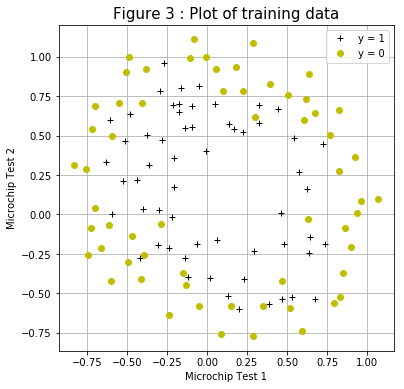

In [14]:
def plotData2():
    plt.plot(pos[:, 1], pos[:, 2], 'k+', label='y = 1')
    plt.plot(neg[:, 1], neg[:, 2], 'yo', label='y = 0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(6, 6))
plotData2()
plt.title("Figure 3 : Plot of training data", fontsize=15)

### 2.2 Feature Mapping 特征映射
如果样本量多，逻辑回归问题很复杂，而原始特征只有x1,x2，  
可以用多项式创建更多的特征x1、x2、x1x2、x1^2、x2^2、... X1^nX2^n等。  
因为更多的特征进行逻辑回归时，得到的决策边界可以是任意高阶函数的形状，可以更加贴合数据。

In [15]:
def mapFeature(x1col, x2col):
    """ 
    特征映射
    方法接收x1和x2两个向量，返回一个m*28矩阵
    """
    degrees = 6  # 最高项的次数
    out = np.ones((x1col.shape[0], 1))

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term = (term1 * term2).reshape(term1.shape[0], 1)
            out = np.hstack((out, term))  # 把向量term合并到矩阵out右侧
    return out  # 输出[1,x1,x2,x1^2,x1*x2,x2^2,...,x2^6]矩阵，其中每一项都是m维向量

# 建立特征映射后的X矩阵
mappedX = mapFeature(X[:, 1], X[:, 2])

### 2.3 代价函数和梯度下降

In [16]:
# 使用之前定义的代价函数
# 输出未经正则化的代价为 0.693
initial_theta = np.zeros((mappedX.shape[1], 1))
computeCost(initial_theta, mappedX, y)

0.6931471805599454

#### 2.3.1 使用 fminunc学得参数
因为fmin不收敛 (passing max # of iterations)，于是改用minimize  
这里使用BFGS算法

In [17]:
def optimizeRegularizedTheta(mytheta, myX, myy, mylambda=0.):
    result = optimize.minimize(computeCost, mytheta, args=(
        myX, myy, mylambda),  method='BFGS', options={"maxiter": 500, "disp": False})
    return np.array([result.x]), result.fun

theta, mincost = optimizeRegularizedTheta(initial_theta, mappedX, y)

### 2.4 绘制决策边界

Text(0.5,1,'Figure 4 : Decision Boundary')

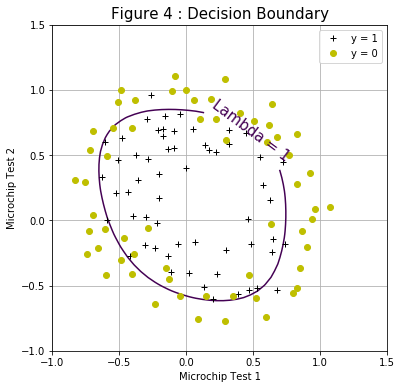

In [21]:
def plotBoundary(mytheta, myX, myy, mylambda=0.):
    """
    用于绘制任意theta，X，y，lambda值的决策边界的函数。
    它的工作原理是制作一个x1（“xvals”）
    和x2（“yvals”）点的网格，并为每个点计算假设是否将该点分类为True或False。
    然后，使用内置的pyplot函数绘制轮廓。
    """
    theta, mincost = optimizeRegularizedTheta(
        mytheta, myX, myy, mylambda)  # 最小化theta
    xvals = np.linspace(-1, 1.5, 50)
    yvals = np.linspace(-1, 1.5, 50)
    zvals = np.zeros((len(xvals), len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(          # 特征映射
                np.array([xvals[i]]), np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta, myfeaturesij.T)
    zvals = zvals.transpose()

    u, v = np.meshgrid(xvals, yvals)
    mycontour = plt.contour(xvals, yvals, zvals, [0])

    # 一种在决策边界上方显示文字的机智的方法
    myfmt = {0: 'Lambda = %d' % mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)

# 绘制决策边界
plt.figure(figsize=(6,6))
plotData2()
plotBoundary(theta, mappedX, y, 1.)
plt.title("Figure 4 : Decision Boundary", fontsize=15)

###  2.5 附加作业
绘制当正则参数lambda取不同值时的图像  
显示当lambda=0时过拟合,lambda=100时欠拟合  

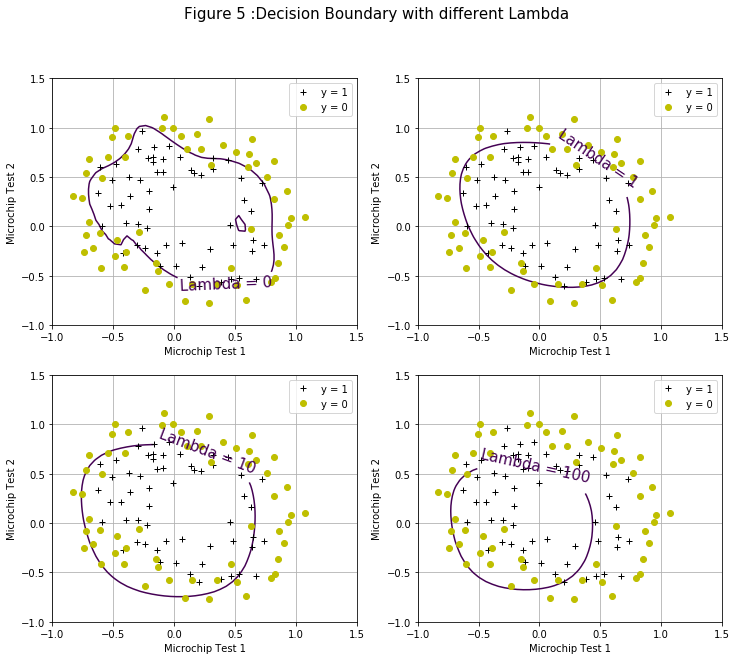

In [29]:
plt.figure(figsize=(12, 10))
plt.suptitle("Figure 5 :Decision Boundary with different Lambda", fontsize=15) # 使用suptitle添加总标题

plt.subplot(221)
plotData2()
plotBoundary(theta, mappedX, y, 0.)

plt.subplot(222)
plotData2()
plotBoundary(theta, mappedX, y, 1.)

plt.subplot(223)
plotData2()
plotBoundary(theta, mappedX, y, 10.)

plt.subplot(224)
plotData2()
plotBoundary(theta, mappedX, y, 100.)